#### Apple Stock Market - Prediction

In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
#Loading Data
df = pd.read_csv('https://raw.githubusercontent.com/krishnaik06/Stock-MArket-Forecasting/master/AAPL.csv')

df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [5]:
df2 = df.reset_index()['close']

In [6]:
df2

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

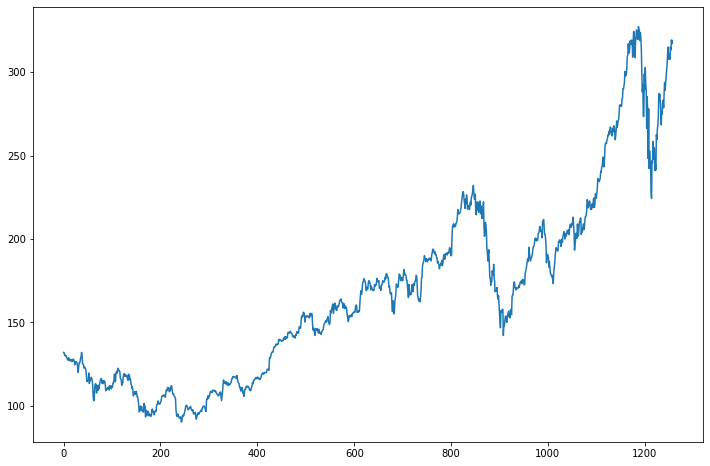

In [7]:
df2.plot(figsize=(12,8))

In [8]:
#Train test split
split_len = int(df2.shape[0]*0.7)

train = np.array(df2[:split_len]).reshape(-1,1)

test = np.array(df2[split_len:]).reshape(-1,1)

In [8]:
train.shape, test.shape

((880, 1), (378, 1))

In [9]:
#scaling the data
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
train_scale = scaler.transform(train)
test_scale = scaler.transform(test)

In [11]:
#time series generator
length = 100
n_feature = 1

train_gen = TimeseriesGenerator(train_scale, train_scale, length=length, batch_size = n_feature)

In [12]:
train_scale.shape

(880, 1)

In [13]:
X, y = train_gen[779]

In [14]:
X.shape

(1, 100, 1)

In [15]:
test_gen = TimeseriesGenerator(test_scale, test_scale, length=length, batch_size = n_feature)

#### Modelling

In [1]:
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

### Simple RNN

In [16]:
train_gen[0][0].shape

(1, 100, 1)

In [115]:
model = Sequential()
model.add(SimpleRNN(128, return_sequences = False, input_shape = (100,1)))
model.add(Dense(1))

In [116]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [117]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_30 (SimpleRNN)    (None, 128)               16640     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [119]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=100, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
850/850 [==============================] - 19s 20ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/100
850/850 [==============================] - 17s 20ms/step - loss: 8.1912e-04 - mse: 8.1912e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 3/100
850/850 [==============================] - 18s 21ms/step - loss: 4.2111e-04 - mse: 4.2111e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/100
850/850 [==============================] - 18s 22ms/step - loss: 4.5673e-04 - mse: 4.5673e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/100
850/850 [==============================] - 17s 20ms/step - loss: 3.8669e-04 - mse: 3.8669e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/100
850/850 [==============================] - 17s 20ms/step - loss: 4.8147e-04 - mse: 4.8147e-04 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/100
850/850 [==============================] - 18s 21ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/100
850

In [120]:
loss = pd.DataFrame(model.history.history)

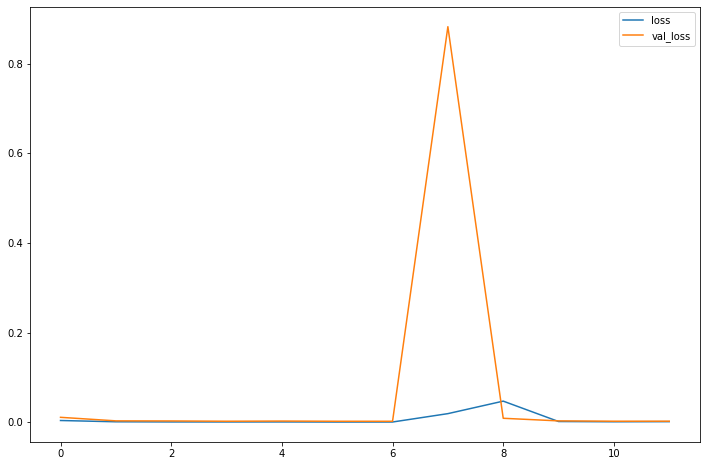

In [26]:
loss[['loss','val_loss']].plot(figsize=(12,8))

In [122]:

test_predictions = []

first_eval_batch = train_scale[-length:]

current_batch = first_eval_batch.reshape((1, length, n_feature))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [123]:
len(test_predictions)

378

In [40]:
test_df = pd.DataFrame({'Actual':test.reshape(-1), 'RNN Pred':test_pred_inverse.reshape(-1)}, index = range(len(test)))

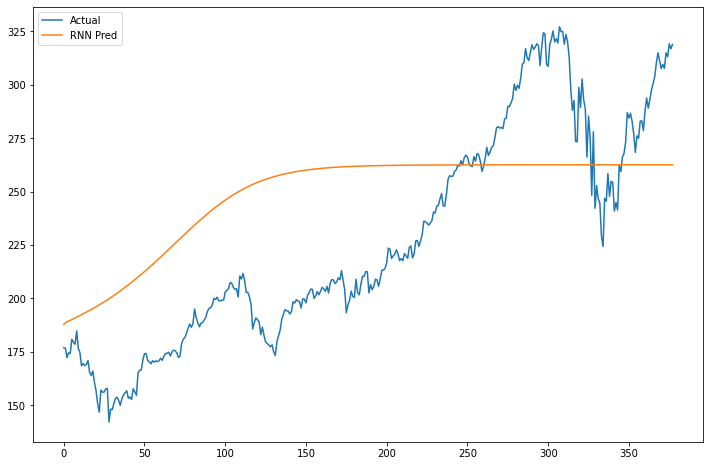

In [43]:
test_df.plot(figsize=(12,8))

In [17]:
def metrics(y_true, y_pred):
  print('MAE:', mean_absolute_error(y_true, y_pred))
  print('MSE:', mean_squared_error(y_true, y_pred))
  print('RMSE:', np.sqrt(mean_squared_error(y_true, y_pred)))

In [46]:
metrics(test_df['Actual'], test_df['RNN Pred'])

MAE: 39.84716754492628
MSE: 1969.7159632994612
RMSE: 44.38148221161007


### Stacked RNN

In [61]:
model = Sequential()
model.add(SimpleRNN(96, return_sequences = True, input_shape = (100,1)))
model.add(SimpleRNN(96, return_sequences = True))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [62]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_26 (SimpleRNN)    (None, 100, 96)           9408      
_________________________________________________________________
simple_rnn_27 (SimpleRNN)    (None, 100, 96)           18528     
_________________________________________________________________
simple_rnn_28 (SimpleRNN)    (None, 64)                10304     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 38,305
Trainable params: 38,305
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=100, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
780/780 [==============================] - 183s 226ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.1030 - val_mse: 0.1030
Epoch 2/100
780/780 [==============================] - 174s 224ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.1124 - val_mse: 0.1124
Epoch 3/100
780/780 [==============================] - 175s 224ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.1138 - val_mse: 0.1138
Epoch 4/100
780/780 [==============================] - 174s 223ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0526 - val_mse: 0.0526
Epoch 5/100
780/780 [==============================] - 173s 222ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 6/100
780/780 [==============================] - 174s 223ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0415 - val_mse: 0.0415
Epoch 7/100
780/780 [==============================] - 173s 222ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 8/100
780/780 [====================

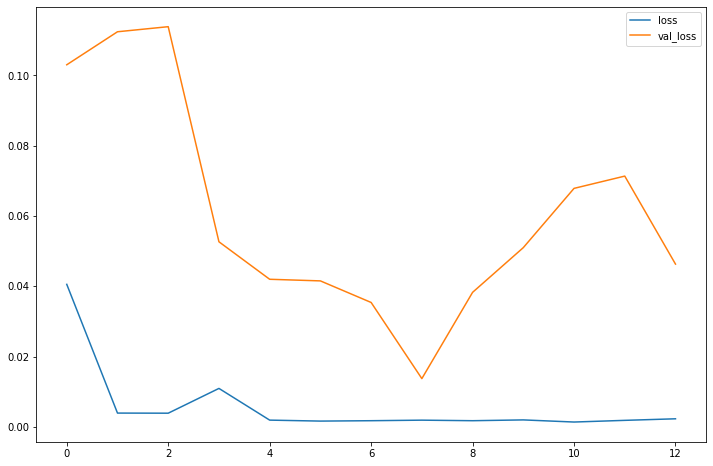

In [64]:
loss = pd.DataFrame(model.history.history)
loss[['loss','val_loss']].plot(figsize=(12,8))

In [65]:
test_predictions = []

first_eval_batch = train_scale[-length:]

current_batch = first_eval_batch.reshape((1, length, n_feature))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [66]:
test_pred_inverse = scaler.inverse_transform(test_predictions)

In [69]:
test_df['Stacked_RNN_Pred'] = test_pred_inverse.reshape(-1)

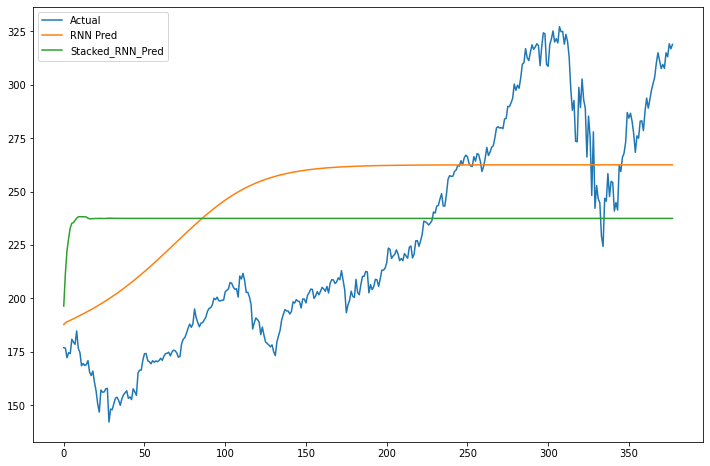

In [72]:
test_df.plot(figsize=(12,8))

In [73]:
metrics(test_df['Actual'], test_df['Stacked_RNN_Pred'])

MAE: 45.83978268784348
MSE: 2648.168221701281
RMSE: 51.46035582563806


### LSTM

In [74]:
model = Sequential()
model.add(LSTM(128, return_sequences = False, input_shape = (100,1)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [75]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=100, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
780/780 [==============================] - 13s 9ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 2/100
780/780 [==============================] - 7s 9ms/step - loss: 8.9566e-04 - mse: 8.9566e-04 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/100
780/780 [==============================] - 7s 9ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/100
780/780 [==============================] - 7s 10ms/step - loss: 6.4830e-04 - mse: 6.4830e-04 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 5/100
780/780 [==============================] - 7s 10ms/step - loss: 5.9630e-04 - mse: 5.9630e-04 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 6/100
780/780 [==============================] - 7s 10ms/step - loss: 5.6448e-04 - mse: 5.6448e-04 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 7/100
780/780 [==============================] - 7s 9ms/step - loss: 4.6338e-04 - mse: 4.6338e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 8/100
780/780 [====

In [78]:
loss = pd.DataFrame(model.history.history)

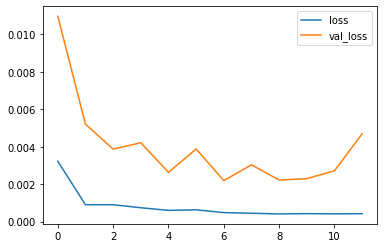

In [80]:
loss[['loss', 'val_loss']].plot()

In [81]:
test_predictions = []

first_eval_batch = train_scale[-length:]

current_batch = first_eval_batch.reshape((1, length, n_feature))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [82]:
test_pred_inverse = scaler.inverse_transform(test_predictions)

In [83]:
test_df['LSTM_Pred'] = test_pred_inverse.reshape(-1)

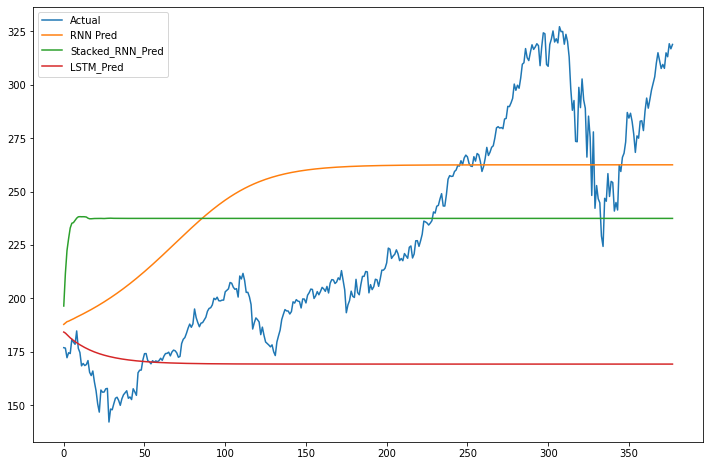

In [84]:
test_df.plot(figsize=(12,8))

In [87]:
metrics(test_df['Actual'], test_df['LSTM_Pred'])

MAE: 60.53770279363507
MSE: 5932.9558793766655
RMSE: 77.0256832451142


### Stacked LSTM

In [88]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [89]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [90]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=100, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
780/780 [==============================] - 23s 25ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/100
780/780 [==============================] - 18s 23ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 3/100
780/780 [==============================] - 17s 22ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 4/100
780/780 [==============================] - 17s 22ms/step - loss: 9.0203e-04 - mse: 9.0203e-04 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 5/100
780/780 [==============================] - 19s 24ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 6/100
780/780 [==============================] - 17s 22ms/step - loss: 9.7825e-04 - mse: 9.7825e-04 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 7/100
780/780 [==============================] - 17s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 8/100
780/780 [==================

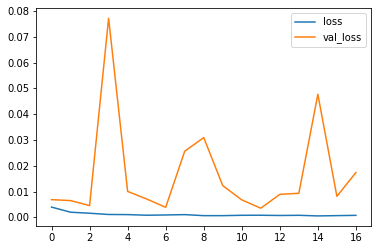

In [91]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()

In [92]:
test_predictions = []

first_eval_batch = train_scale[-length:]

current_batch = first_eval_batch.reshape((1, length, n_feature))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_pred_inverse = scaler.inverse_transform(test_predictions)

In [93]:
test_df['Stacked_LSTM_Pred'] = test_pred_inverse.reshape(-1)

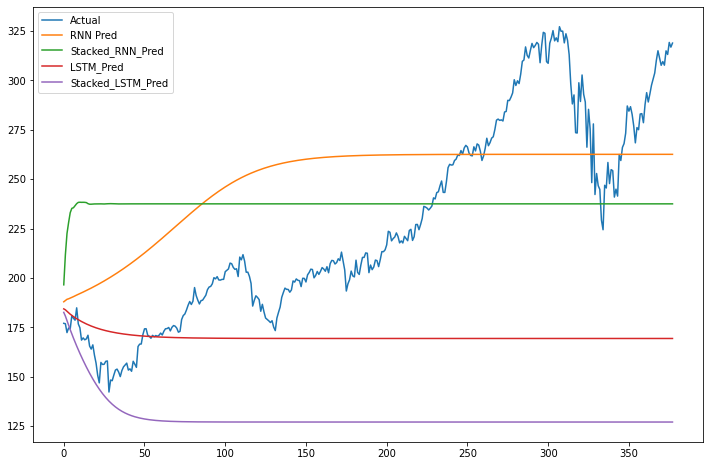

In [94]:
test_df.plot(figsize=(12,8))

In [96]:
metrics(test_df['Actual'], test_df['Stacked_LSTM_Pred'])

MAE: 97.75596319185206
MSE: 12485.037573494517
RMSE: 111.73646483352924


### Drop Out Stacked LSTM

In [130]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (100,1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True,))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [131]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 100, 128)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 128)          131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

In [132]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=100, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
850/850 [==============================] - 14s 12ms/step - loss: 0.0123 - mse: 0.0123 - val_loss: 0.0410 - val_mse: 0.0410
Epoch 2/100
850/850 [==============================] - 9s 11ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 3/100
850/850 [==============================] - 9s 11ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 4/100
850/850 [==============================] - 9s 11ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/100
850/850 [==============================] - 10s 12ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 6/100
850/850 [==============================] - 10s 12ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0398 - val_mse: 0.0398
Epoch 7/100
850/850 [==============================] - 10s 11ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 8/100
850/850 [==============================] - 9s 

In [133]:
loss = pd.DataFrame(model.history.history)

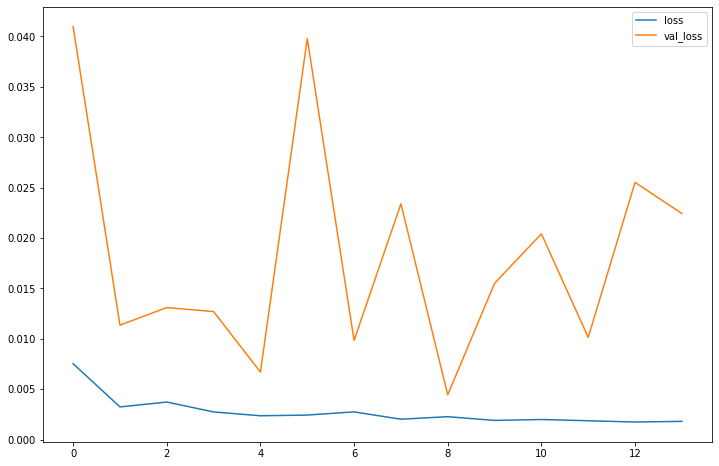

In [137]:
loss[['loss', 'val_loss']].plot(figsize = (12,8))

In [139]:
length

30

In [141]:
test_predictions = []

first_eval_batch = train_scale[-100:]

current_batch = first_eval_batch.reshape((1, 100, n_feature))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_pred_inverse = scaler.inverse_transform(test_predictions)

In [142]:
test_df['DropOut_LSTM_Pred'] = test_pred_inverse.reshape(-1)

In [143]:
metrics(test_df['Actual'], test_df['DropOut_LSTM_Pred'])

MAE: 41.81869623594657
MSE: 2919.5076100791593
RMSE: 54.03246811019426


### Bidirectional LSTM

In [18]:
model = Sequential()
model.add(LSTM(96, return_sequences = True, input_shape = (100,1)))
model.add(Bidirectional(LSTM(96, return_sequences = False)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 96)           37632     
_________________________________________________________________
bidirectional (Bidirectional (None, 192)               148224    
_________________________________________________________________
dense (Dense)                (None, 1)                 193       
Total params: 186,049
Trainable params: 186,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit_generator(train_gen, validation_data=test_gen, epochs=100, callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
780/780 [==============================] - 42s 23ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 2/100
780/780 [==============================] - 17s 22ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 8.7680e-04 - mse: 8.7680e-04 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 4/100
780/780 [==============================] - 16s 21ms/step - loss: 8.7902e-04 - mse: 8.7902e-04 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 5/100
780/780 [==============================] - 17s 22ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 6/100
780/780 [==============================] - 17s 22ms/step - loss: 6.7354e-04 - mse: 6.7354e-04 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 7/100
780/780 [==============================] - 16s 21ms/step - loss: 5.7261e-04 - mse: 5.7261e-04 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/100
780/780 [==

In [22]:
loss = pd.DataFrame(model.history.history)

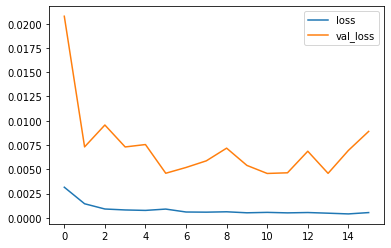

In [24]:
loss[['loss', 'val_loss']].plot()

In [26]:
test_predictions = []

first_eval_batch = train_scale[-100:]

current_batch = first_eval_batch.reshape((1, 100, n_feature))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

test_pred_inverse = scaler.inverse_transform(test_predictions)

In [27]:
test_df = pd.DataFrame({'Actual':test.reshape(-1), 'Bi-direct-LSTM Pred':test_pred_inverse.reshape(-1)}, index = range(len(test)))

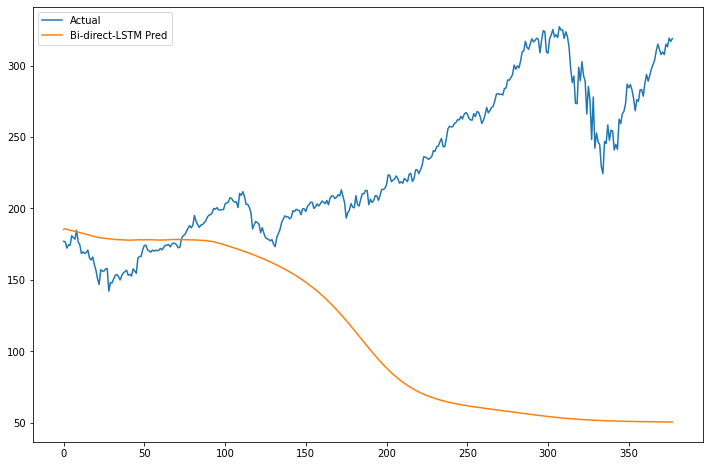

In [28]:
test_df.plot(figsize = (12,8))

In [29]:
metrics(test_df['Actual'], test_df['Bi-direct-LSTM Pred'])

MAE: 119.91145594171275
MSE: 23565.919074664216
RMSE: 153.51195091804487
